<a href="https://www.kaggle.com/code/akouaorsot/restaurant-revenue-s-predictions?scriptVersionId=128913825" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Restaurant Revenue
As probably the riskiest business out there, restaurants face fierce competition across the board as well as an increasingly more demanding customer base. Thre are so many things that would go into making a restaurant successful in its spefici cuisine or location. In that vein, this notebook will analyze different variables driving revenues for a restaurant by building a predictive algortihm.In doing so, we will follow LIME (Local Interpretable Model-agnostic Explanations) principles making it accessible and user-friendly to most readers. 

## Table of Contents
1. Environment set-up
    * Importing Libraries
    * Loading the data
2. Initial Diagnostics
    * Glimpse
    * Descriptive Statitics
    * Target Variable Analysis
    * Predictors Analysis   
3. Data Processing
    * Basic cleanup
    * Outliers Detection 
4. Inquiry Exploration
    * Does bigger means pricier houses?
    * Where is the real estate hotspot?
    * Which miscellaneous feature add the most value?   
5. Feature Engineering
    * Outliers - Feature Scaling
    * Categorical Encoding
    * Datetime Variables
6. Correlation Analysis
7. Machine Learning (ML) set-up
8. ML Model Building
9. Hyperparameter Tuning
10. Final Submission

# 1. Environment Set-up

In [1]:
## Importing Libraries
import warnings
warnings.filterwarnings("ignore")

#Set seed
import random
random.seed(1234)

# Time function
import time

# Regex
import re

# Statiscal methods
from math import sqrt
from scipy import stats

# Manipulating & Visualizing Data
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.impute import SimpleImputer as imp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 8)})

# Categorical Encoding
import category_encoders as ce

# Feature Scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# Sampling Methods
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

# Dimensionality Reduction
from sklearn.decomposition import PCA, TruncatedSVD

# ML Models
import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Ensemble Learning
import sklearn.ensemble as esmb
from xgboost import XGBRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Performance metrics
import sklearn.metrics as skm

In [2]:
raw_data = pd.read_csv('/kaggle/input/restaurant-revenue-prediction/train.csv.zip')
raw_data.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


# 2. Initial Diagnostics

In [3]:
# General info on the dataset
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 43 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          137 non-null    int64  
 1   Open Date   137 non-null    object 
 2   City        137 non-null    object 
 3   City Group  137 non-null    object 
 4   Type        137 non-null    object 
 5   P1          137 non-null    int64  
 6   P2          137 non-null    float64
 7   P3          137 non-null    float64
 8   P4          137 non-null    float64
 9   P5          137 non-null    int64  
 10  P6          137 non-null    int64  
 11  P7          137 non-null    int64  
 12  P8          137 non-null    int64  
 13  P9          137 non-null    int64  
 14  P10         137 non-null    int64  
 15  P11         137 non-null    int64  
 16  P12         137 non-null    int64  
 17  P13         137 non-null    float64
 18  P14         137 non-null    int64  
 19  P15         137 non-null    i

In [4]:
raw_data.describe()

,Id,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02
mean,68.000000,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,...,3.135036,2.729927,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06
std,39.692569,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,...,1.680887,5.536647,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06
min,0.000000,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06
25%,34.000000,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,...,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06
50%,68.000000,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06
75%,102.000000,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,...,3.000000,4.000000,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06
max,136.000000,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,...,7.500000,25.000000,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07


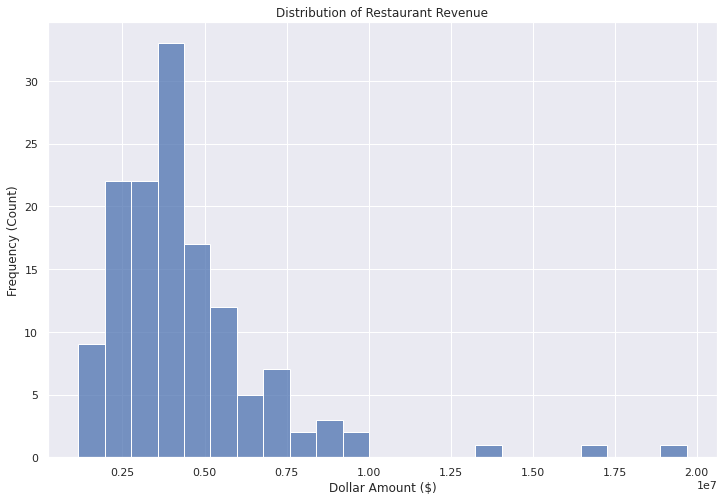

In [5]:
## Feature Variable Analysis
sns.histplot(data=raw_data, x='revenue')
plt.xlabel("Dollar Amount ($)")
plt.ylabel("Frequency (Count)")
plt.title("Distribution of Restaurant Revenue")
plt.show()

**Takeaway:** From the histogram above, we can deduct that restaurant revenue in this dataset have a right-skewed distribution with outliers on the upper end, indicating some business with higher revenues than others making on average ~USD 4.4M. The lowest revenues stands in the range between ~USD 1.15MM and ~USD 19.7MM.

# 3. Data Processing

In [6]:
## Simple processing steps
def basic_processing(data, col_drop = [], col_rename=dict()):
    """ Basic data processing: drop/rename columns, remove duplicate(s)
    
    Parameters
    ----------
    data : dataframe
        A dataset
    col_drop : list
        A list of column names to drop
    col_rename : dict
        A dictionary pairing the old and new column names desired

    Returns
    -------
    data
        a modified dataframe
    """ 
    #Drop the 'Serial No.' column
    if len(col_drop) > 0:
        data.drop(col_drop, axis=1, inplace=True)

    # Renaming the target variable and one predictor
    if col_rename:
        data.rename(columns=col_rename, inplace=True)
    
    # Removing any Duplicate Observations if any
    data.drop_duplicates(keep='first', inplace=True)
    return data

In [7]:
df = basic_processing(raw_data, col_rename={"revenue": "target"})
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,target
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [8]:
# Identify missing values and dealing with them if present
def identify_missing_val(data):
    """ Identify missing/na values
    
    Parameters
    ----------
    data : dataframe
        A dataset

    Returns
    -------
    data
        a dataframe with no missing values 
        either after imputation or original format
    """
    
    # Count number of missing values 
    sum_na = data.isnull().sum().sum()
    print("%d null/na values found in the dataset." % sum_na)
    
    # Only visualize if missing values present
    if sum_na > 0: 
        plt.figure(figsize=(10,6))
        sns.heatmap(df.isna().transpose(),
                    cmap="YlGnBu",
                    cbar_kws={'label': 'Missing Data'})
        plt.xlabel("Features")
        plt.ylabel("Observations")
        plt.show()
        
        # Proceeding in imputing the dataset with missing values
        null_cols = data.columns[data.isnull().any()].tolist()
        print('Those columns have missing values in those count and proportions:')
        for i in null_cols:
            col_null = data[i].isnull().sum()
            per_null = col_null / len(df[i])
            print("  - {}: {} ({:.2%})".format(i, col_null, per_null))
        #print(*null_cols, sep = "\n") 
    else:
        print("- No action needed")
        pass
    return data

In [9]:
df = identify_missing_val(df)

0 null/na values found in the dataset.
- No action needed


In [10]:
# Detecting outliers using z-score
def outliers_detection(data, threshold=3):
    """ Function to detect outliers
    
    Parameters
    ----------
    data : dataframe
        A dataset
    threshold:
        The threshold at which a value is an outlier
        ±2.5σ from the µ

    Returns
    -------
    data
        a dataframe with no missing values 
        either after imputation or original format
    """
    print("At ±", threshold, "standard deviation from the mean:")
    for col in data.columns[:-1]:
        if data[col].dtype.kind in 'iufc':
            # Calculating the z-score for each predictor
            var = data[col]
            z = np.abs(stats.zscore(var))

            # Outlier
            pos = list(np.where(z > threshold)[0])
            no_of_outliers = len(pos)
            if no_of_outliers > 0:
                print("\t- ", col, "variable contains", no_of_outliers,  "outliers")
        else:
            continue

In [11]:
outliers_detection(df)

At ± 3 standard deviation from the mean:
	-  P3 variable contains 3 outliers
	-  P4 variable contains 4 outliers
	-  P5 variable contains 3 outliers
	-  P6 variable contains 5 outliers
	-  P11 variable contains 3 outliers
	-  P14 variable contains 3 outliers
	-  P15 variable contains 4 outliers
	-  P16 variable contains 3 outliers
	-  P17 variable contains 2 outliers
	-  P18 variable contains 9 outliers
	-  P19 variable contains 6 outliers
	-  P21 variable contains 3 outliers
	-  P23 variable contains 5 outliers
	-  P24 variable contains 2 outliers
	-  P25 variable contains 6 outliers
	-  P26 variable contains 6 outliers
	-  P27 variable contains 2 outliers
	-  P28 variable contains 2 outliers
	-  P30 variable contains 8 outliers
	-  P31 variable contains 5 outliers
	-  P32 variable contains 6 outliers
	-  P34 variable contains 10 outliers
	-  P35 variable contains 1 outliers
	-  P36 variable contains 6 outliers
	-  P37 variable contains 1 outliers


**Takeaway:** As we thought about handling those outliers, we decided to keep them all since ggood data science practices advocates to conserve as many data points as possible. Thus, allowing us to limit the biases simply to produce a better fitting model or statistically significant results.

# 5. Feature Engineering

## Datetime Variables: 

There are variables denoting dates and thus, may hold significance and impact our target variable: the house's sale price. 

Based on research, we thought that the most sensible option would be to transform the datetime variables into ordinal categories in twofold:
 - Direct encoding of 'MoSold' and 'YrSold' having 12 and 5 pre-defined categories that are the 12 months and 5 years respectively during which the houses in the dataset were sold.
 - Binning of 'YearRemodAdd' and 'YearBuilt' into 6 categories of 10 and 20 years of interval respectively before proceding to ordinal encoding as well.

In [12]:
## Categorical Encoding
def datetime_encoding(df, cols):
    """ Creating time intervals
    """
    # Slicing time into intervals
    for c in cols:
        df[c+'_month'] = pd.DatetimeIndex(df[c]).month
        df[c+'_month'] = df[c+'_month'].astype("category").cat.codes
        
        df[c+'_year'] = pd.DatetimeIndex(df[c]).year
        df[c+'_year'] = df[c+'_year'].astype("category").cat.codes

    return df

In [13]:
df = datetime_encoding(df, cols=['Open Date'])
df

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P31,P32,P33,P34,P35,P36,P37,target,Open Date_month,Open Date_year
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3,4,5,5,4,3,4,5653753.0,6,3
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,0,0,0,0,0,0,0,6923131.0,1,10
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,0,0,0,0,0,0,0,2055379.0,2,15
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,12,10,6,18,12,12,6,2675511.0,1,14
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,1,3,2,3,4,3,3,4316715.0,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,0,0,0,0,0,0,0,5787594.0,5,10
133,133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,0,0,0,0,0,0,0,9262754.0,9,8
134,134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,0,0,0,0,0,0,0,2544857.0,6,8
135,135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,0,0,0,0,0,0,0,7217634.0,9,12


## Categorical feature encoding

It ensures that variables with categories/groupings are transformed into numerical inputs for the predictive modeling phase. The categorical variables are also subdivided as:
- binary (two possible outcomes)
- cardinal (no meaningful order) 
- ordinal (meaningful order) 

Read more [here](https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/).

In [14]:
## Categorical Encoding
def categorical_encoding(df, binary_vars=[], nominal_vars=[], ordinal_cols_mapping={}):
    """ Function encoding  categorical variables
    
    Parameters
    ----------
    data : dataframe
        A dataset
        
    binary_vars, nominal_vars:
        List of binary and nominal categorical variables, respectively
    
    ordinal_cols_mapping:
        List of dictionary mapping the corresponding order of each category

    Returns
    -------
    data_encoded
        a dataframe with all categorical encoding transfomation
    """

    # Binary - Applying binary encoder
    binenc = ce.BinaryEncoder(cols = binary_vars, return_df = True)
    df = binenc.fit_transform(df)  
    
    # Nominal - Applying One-Hot encoder 
    for c in nominal_vars:
        df[c] = df[c].astype("category").cat.codes
        df[c] = df[c]

    # Ordinal - Applying Ordinal encoder 
    ordenc = ce.OrdinalEncoder(mapping = ordinal_cols_mapping, return_df = True)
    df_final = ordenc.fit_transform(df)  
    
    return df_final

In [15]:
# Encoding Categorical Variable
cat_vars = ['City', 'City Group', 'Type']
df = categorical_encoding(df, nominal_vars=cat_vars)
df

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P31,P32,P33,P34,P35,P36,P37,target,Open Date_month,Open Date_year
0,0,07/17/1999,31,0,2,4,5.0,4.0,4.0,2,...,3,4,5,5,4,3,4,5653753.0,6,3
1,1,02/14/2008,3,0,1,4,5.0,4.0,4.0,1,...,0,0,0,0,0,0,0,6923131.0,1,10
2,2,03/09/2013,10,1,2,2,4.0,2.0,5.0,2,...,0,0,0,0,0,0,0,2055379.0,2,15
3,3,02/02/2012,28,1,2,6,4.5,6.0,6.0,4,...,12,10,6,18,12,12,6,2675511.0,1,14
4,4,05/09/2009,14,1,2,3,4.0,3.0,4.0,2,...,1,3,2,3,4,3,3,4316715.0,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,29,1,1,2,3.0,3.0,5.0,4,...,0,0,0,0,0,0,0,5787594.0,5,10
133,133,10/12/2006,32,0,1,4,5.0,4.0,4.0,2,...,0,0,0,0,0,0,0,9262754.0,9,8
134,134,07/08/2006,18,1,1,3,4.0,4.0,4.0,2,...,0,0,0,0,0,0,0,2544857.0,6,8
135,135,10/29/2010,31,0,1,4,5.0,4.0,5.0,2,...,0,0,0,0,0,0,0,7217634.0,9,12


# 4. Correlation Analysis

**Note:** In addition to displaying the correlation matrix, we will also filter out relatively and highly correlated relationship with coefficient between 0.85 and 1 (non-inclusive to avoid pairs of identical variables). It would help identify possible risks of multi-collinearity.

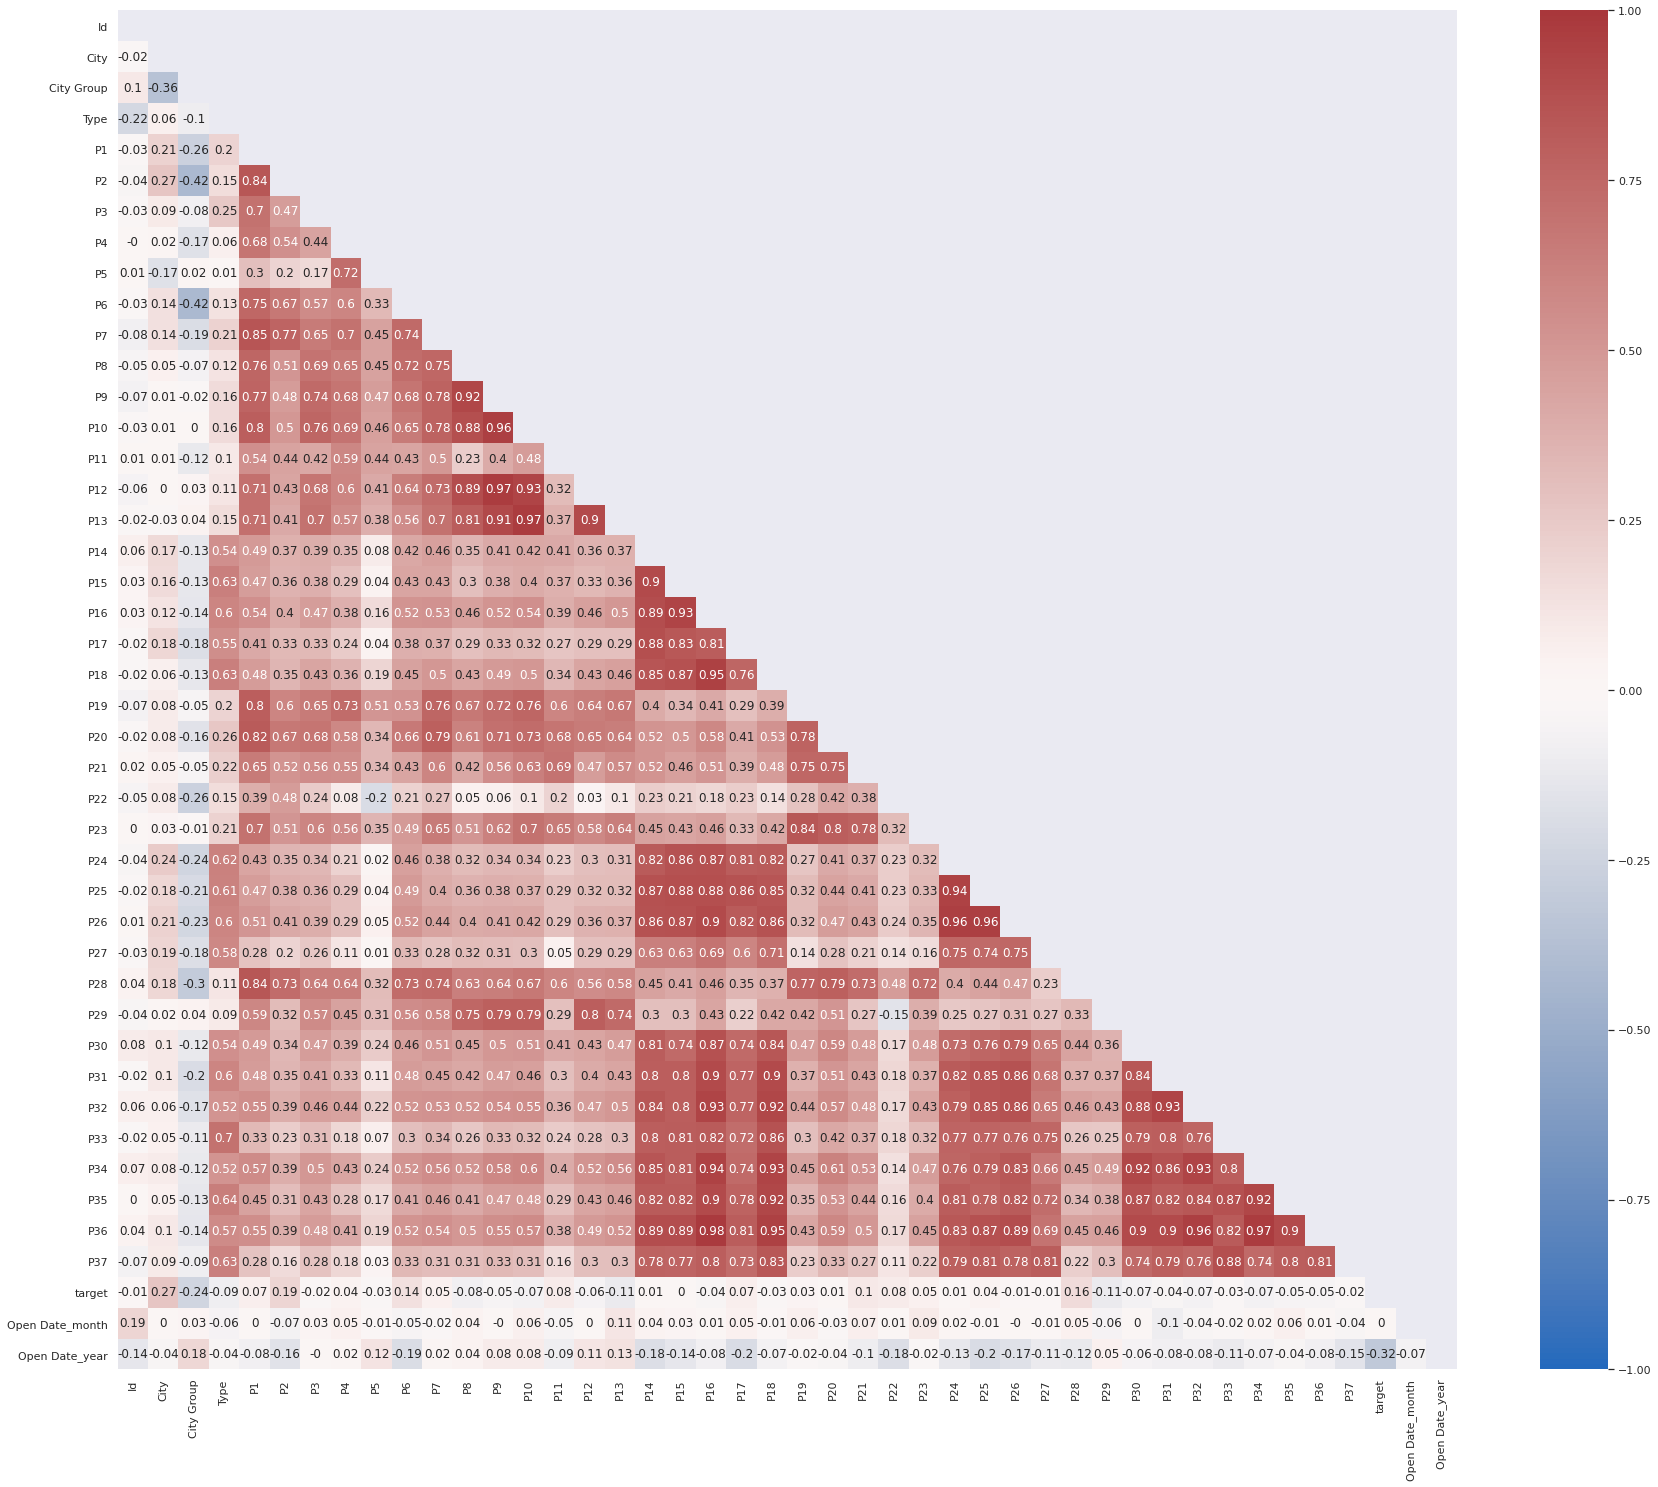

In [16]:
# Correlation Matrix
f = plt.figure(figsize=(30,25))
matrix = df.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, 
            center=0, cmap='vlag', mask=mask)
plt.show()

In [17]:
## Strongest Relationships
matrix_corr = df.corr()
matrix_corr = np.round(matrix_corr.unstack(), 2)
strong_rel = matrix_corr[(abs(matrix_corr) >= 0.9) & (abs(matrix_corr) != 1.00)]
strong_rel

P8   P9     0.92
P9   P8     0.92
     P10    0.96
     P12    0.97
     P13    0.91
            ... 
P36  P30    0.90
     P31    0.90
     P32    0.96
     P34    0.97
     P35    0.90
Length: 66, dtype: float64

# 5. Inquiry Exploration

In this section, we will generate various questions to further consolidate our understanding of the problem at hand. It will allow us to guide the machine learning process more attuned to the particular subject matter.

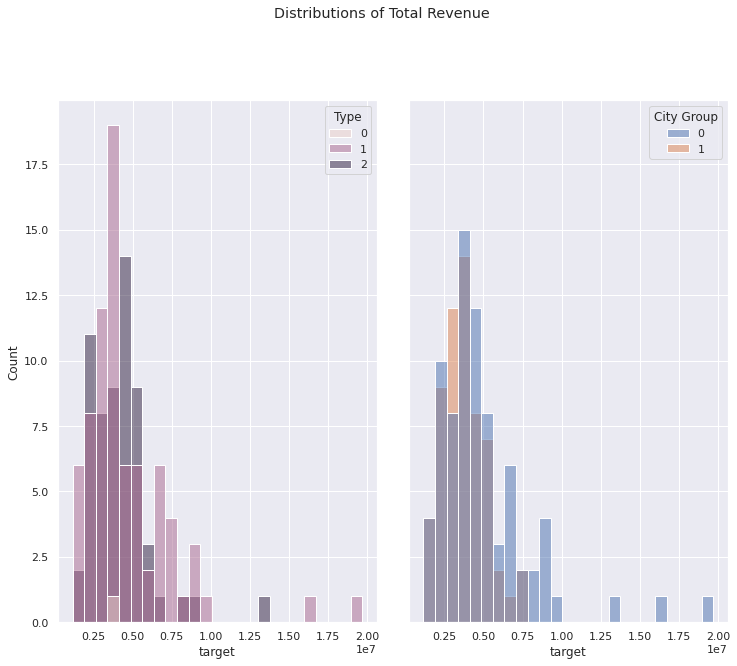

In [18]:
# Distribution of target variable (revenue) by Type and by City Group
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(1, 2, hspace=0.7, wspace=0.1)
(ax1, ax2) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Distributions of Total Revenue')
fig.subplots_adjust(top=0.85)

sns.histplot(data=df, x='target', bins=25,hue='Type', ax=ax1)
sns.histplot(data=df, x='target', bins=25,hue='City Group', ax=ax2)

plt.show()

# 6. Machine Learning set-up

Under this section, we will explain the procedure of two main splitting approach to estimate our models' performance. 

**Model Selection methods:** 
* **Train_test_split**: Often denoted as the most popular by its simplicity, the train-test split is a sampling technique dividing the dataset between training and testing sets. In doing so, the goal would be to have enough (but not too much) in our training set used for the machine learning model to predict the observations in the testing set as accurately as possible. Most would opt for a 70/30 training-testing split, respectively, others 80/20, 60/40, or whichever else works best for the case scenario. Further information [here](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). 

* **Cross-validation**: As the name would suggest, we will engage here in the process of validation to ensure reliability on our model. Cross-Validation is a statistical method applied in various ways to estimate the model's performance. Some examples are **Holdout Method, K-Fold, Stratified K-Fold, Leave-P-Out.**  Further information [here](https://machinelearningmastery.com/k-fold-cross-validation/) and [here](https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f).

In [19]:
def model_comparison(df, models, 
                     cols=['target', 'Open Date'],  
                     metric='neg_mean_squared_error'):
    
    """ Function to split data into training and testing set
    
    Parameters
    ----------
    data : dataframe
        A dataset
    models: A dictionary
        A pre-defined dictionary with each model name and applicable function
    
    optional train_test params
    
    Returns
    -------
    models_df
        A dataframe with each model performance
    """
    
    # Splitting features & target variable
    X = df.drop(columns=cols, axis=1)
    y = df['target']
    
    # Obtain training and testing sets from function above
    #X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    # Craete dictionary to save performance data 
    models_perf = {'Models': [], 'CV_RMSE_mean': [], 'CV_RMSE_std': []}
    
    # Obtain model performance across K-Fold using Cross-Validation 
    for model in models:
        cv_results = cross_validate(model, X, y, 
                                    cv=5, scoring=metric)
        cv_rmse = np.sqrt(abs(cv_results['test_score']))
        m = str(model)
        m = m[m.find(".")+1:m.find("(")]
        models_perf['Models'].append(m)
        models_perf['CV_RMSE_mean'].append(np.mean(cv_rmse))
        models_perf['CV_RMSE_std'].append(np.std(cv_rmse))
    
    
    models_df = pd.DataFrame(models_perf, columns = ['Models', 
                                                     'CV_RMSE_mean', 
                                                     'CV_RMSE_std'])
    return models_df

# 7. Machine Learning - Model Building

* **Simple Methods:** We will leverage the powerful sci-kit-learn package to build multiple models with little to no parameter tuning for comparison. We will only use the cross-validation error on our training dataset to avoid any data leakage.

* **Ensemble Methods:** We will extend our work in machine learning to incorporate ensemble methods. We generated simple models and compared the scores, which appear satisfactory; however, we may want more stability and minor variation in our predictive algorithm; it is where ensemble techniques come in. Most often, they act as a 'superposer' of multiple models throughout various ways and thus, bolster their predictive power. Further Information [here](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/). 

In [20]:
# Simple ML Models
models_simple = [lm.LinearRegression(), lm.ElasticNet(), lm.BayesianRidge(), 
                 DecisionTreeRegressor(), SVR(), KNeighborsRegressor()]

# Model Comparison
model_comparison(df, models_simple)

,Models,CV_RMSE_mean,CV_RMSE_std
0,LinearRegression,4.066398e+06,1.451539e+06
1,ElasticNet,2.719195e+06,6.468353e+05
2,BayesianRidge,2.504076e+06,5.948297e+05
3,DecisionTreeRegressor,3.189043e+06,4.585363e+05
4,SVR,2.550721e+06,6.145903e+05
5,KNeighborsRegressor,2.666724e+06,5.934609e+05


In [21]:
# List of ML ensemble models
models_ensemble = [esmb.RandomForestRegressor(), esmb.BaggingRegressor(),
                   esmb.AdaBoostRegressor(), esmb.GradientBoostingRegressor(), 
                   XGBRegressor()]

# Model Comparison
model_comparison(df, models_ensemble)

,Models,CV_RMSE_mean,CV_RMSE_std
0,RandomForestRegressor,2.531919e+06,338849.995882
1,BaggingRegressor,2.715724e+06,331503.267503
2,AdaBoostRegressor,2.599247e+06,307111.572158
3,GradientBoostingRegressor,2.591525e+06,334375.770387
4,XGBRegressor,2.779461e+06,337581.200119
